In [158]:
# from cdlib.algorithms import louvain
# from cdlib import evaluation
import networkx as nx
from ema_workbench import load_results
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from ema_workbench.analysis import pairs_plotting
from ema_workbench.analysis import feature_scoring
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench import RealParameter, IntegerParameter, ScalarOutcome, Constant, Model
from SALib.analyze import sobol
import pickle


In [159]:
# g = nx.karate_club_graph()
# communities = louvain(g)
# print(type(communities))
# print(communities.communities)
# mod = evaluation.modularity_overlap(g, communities)
# print("Overlapping modularity:", mod.score)

# Metrics for communities
# https://cdlib.readthedocs.io/en/v0.2.2/reference/evaluation.html
# Tutorial
# https://colab.research.google.com/github/KDDComplexNetworkAnalysis/CNA_Tutorials/blob/master/CDlib_tutorial.ipynb#scrollTo=3iPbWABt9sj7

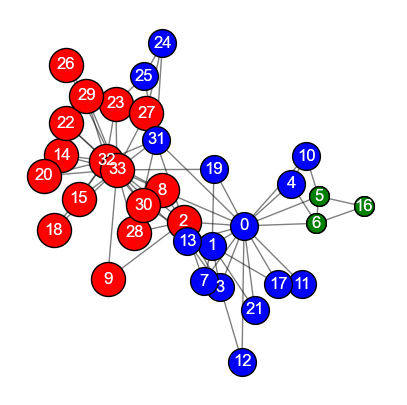

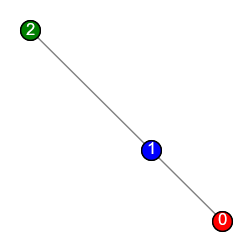

In [160]:
from cdlib import algorithms
from cdlib import viz

g = nx.karate_club_graph()
lp_coms = algorithms.label_propagation(g)

pos = nx.spring_layout(g)
viz.plot_network_clusters(g, lp_coms, pos, figsize=(5, 5), plot_overlaps=True, plot_labels=True) #, top_k=2)
viz.plot_community_graph(g, lp_coms, figsize=(3, 3), plot_overlaps=False, plot_labels=True)
plt.show()

In [161]:
# viz.plot_com_properties_relation([leiden_coms, lp_coms], evaluation.size, evaluation.internal_edge_density)
# from cdlib import evaluation

# g = nx.karate_club_graph()

# lp_coms = algorithms.label_propagation(g)
# #leiden_coms = algorithms.leiden(g)
# wp_coms = algorithms.walktrap(g)
# infomap_coms = algorithms.infomap(g)

# viz.plot_sim_matrix([lp_coms, wp_coms, infomap_coms], evaluation.adjusted_mutual_information)
# plt.show()

In [162]:
filename = './jpetstore/jpetstore_128scenarios_nopolicies_sobol' #.tar.gz'
#filename = './cargo/cargo_128scenarios_nopolicies_sobol' #.tar.gz'


experiments_df, outcomes = load_results(filename+ '.tar.gz')
experiments_df['beta'] = 100 - experiments_df['alpha']
outcomes_df = pd.DataFrame(outcomes)
print(experiments_df.shape, outcomes_df.shape)

with open(filename+'_sa.pkl', 'rb') as input:
    uncertainties_problem = pickle.load(input)
with open(filename+'_graphs.pkl', 'rb') as input:
    graphs_dict = pickle.load(input)
    print(len(graphs_dict.keys()), "graphs")

(1280, 8) (1280, 2)
1207 graphs


In [163]:
experiments_df.head()

,alpha,mfuzzy,microservice_threshold,resolution,scenario,policy,model,beta
0,11,4,4,79,0,NaN,jpetstore,89
1,85,4,4,79,1,NaN,jpetstore,15
2,11,10,4,79,2,NaN,jpetstore,89
3,11,4,10,79,3,NaN,jpetstore,89
4,11,4,4,1,4,NaN,jpetstore,89


In [164]:
experiments_df.describe()

,alpha,mfuzzy,microservice_threshold,resolution,beta
count,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000
mean,50.515625,6.000000,5.996094,50.562500,49.484375
std,28.795465,2.584007,2.577187,28.869432,28.795465
min,1.000000,2.000000,2.000000,1.000000,0.000000
25%,25.750000,4.000000,4.000000,25.750000,24.750000
50%,50.500000,6.000000,6.000000,50.500000,49.500000
75%,75.250000,8.000000,8.000000,75.250000,74.250000
max,100.000000,10.000000,10.000000,100.000000,99.000000


In [165]:
outcomes_df.head()

,n_partitions,modularity
0,7,-0.004216
1,7,-0.004216
2,8,-0.003689
3,7,-0.006579
4,9,-0.003279


In [166]:
outcomes_df.describe()

,n_partitions,modularity
count,1280.000000,1280.000000
mean,7.189063,-0.006265
std,0.829597,0.007682
min,5.000000,-0.082507
25%,7.000000,-0.004919
50%,7.000000,-0.004216
75%,8.000000,-0.004216
max,10.000000,-0.002850


In [167]:
# Visualization of scenarios
def show_pairplot(experiments, outcomes, kind='sns', title='', group='scenario', filename=None):
    if kind == 'sns':
        data = pd.DataFrame(outcomes)
        policies = experiments['scenario']
        data['scenario'] = policies
        g = sns.pairplot(data, hue=group, vars=list(outcomes.keys()), corner=True, plot_kws={'alpha':0.25})
        g._legend.remove()
        g.fig.suptitle(title)
        if filename is not None:
            plt.savefig(filename)
        plt.show()
    if kind == 'matplotlib':
        data = experiments.copy()
        data['scenario'] = experiments['scenario'].astype(str)
        fig, axes = pairs_plotting.pairs_scatter(data, outcomes, group_by=group,legend=False)
        fig.set_size_inches(8,8)
        fig.suptitle(title)
        if filename is not None:
            plt.savefig(filename)
        plt.show()

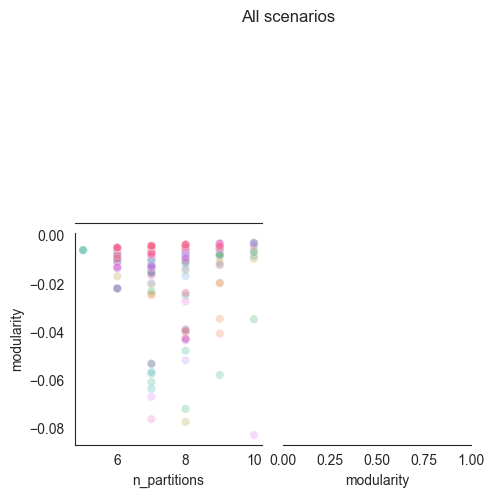

In [168]:
show_pairplot(experiments_df, outcomes, title='All scenarios', kind='sns')
#show_pairplot(experiments_df, outcomes, title='All scenarios (jpetstore)', kind='matplotlib', filename='all_scenarios_jpetstore.png')
#show_pairplot(experiments_df, outcomes, title='All scenarios (cargo)', kind='matplotlib', filename='all_scenarios_cargo.png')

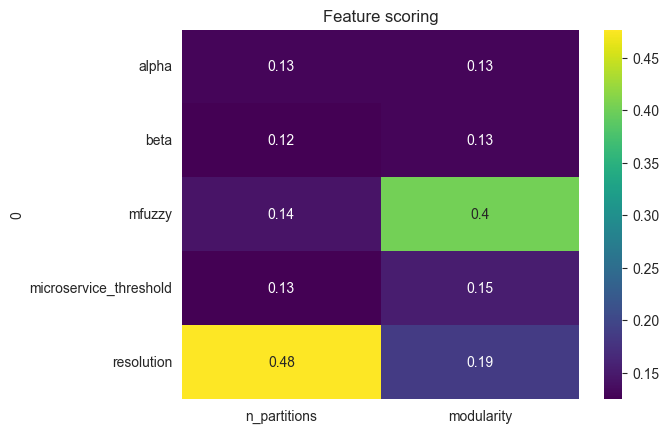

,n_partitions,modularity
0,,
alpha,0.129167,0.129275
beta,0.124658,0.130057
mfuzzy,0.143720,0.401593
microservice_threshold,0.125737,0.152917
resolution,0.476718,0.186158


In [169]:
fs = feature_scoring.get_feature_scores_all(experiments_df, outcomes) #, mode=feature_scoring.CLASSIFICATION)
sns.heatmap(fs, cmap='viridis', annot=True)
plt.title('Feature scoring')
#plt.title('Feature scoring (jpetstore)')
#plt.savefig('feature-scoring-jpetstore.png')
#plt.title('Feature scoring (cargo)')
#plt.savefig('feature-scoring-cargo.png')
plt.show()
fs

In [170]:
# For parameters
# uncertainties_problem = get_SALib_problem(model.uncertainties)
print('----', 'n_partitions')
Si_1 = sobol.analyze(uncertainties_problem, outcomes['n_partitions'], calc_second_order=True, print_to_console=True)
print('----', 'modularity')
Si_2 = sobol.analyze(uncertainties_problem, outcomes['modularity'], calc_second_order=True, print_to_console=True)

---- n_partitions
                              ST   ST_conf
alpha                   0.628236  0.208058
mfuzzy                  0.695987  0.209398
microservice_threshold  0.677509  0.220520
resolution              1.120970  0.286859
                              S1   S1_conf
alpha                  -0.149476  0.158203
mfuzzy                 -0.040939  0.208417
microservice_threshold -0.060244  0.146937
resolution              0.449466  0.259090
                                            S2   S2_conf
(alpha, mfuzzy)                       0.140833  0.266094
(alpha, microservice_threshold)       0.165470  0.237659
(alpha, resolution)                   0.227062  0.286868
(mfuzzy, microservice_threshold)      0.201444  0.308608
(mfuzzy, resolution)                  0.090578  0.305292
(microservice_threshold, resolution)  0.124165  0.270560
---- modularity
                              ST   ST_conf
alpha                   0.595322  0.516278
mfuzzy                  1.141896  0.803928
microser

In [171]:
def show_sobol(problem, Si, title='', filename=None):
    scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

    sns.set_style('white')
    fig, ax = plt.subplots(1)

    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]

    indices.plot.bar(yerr=err.values.T,ax=ax)
    fig.set_size_inches(8,6)
    fig.subplots_adjust(bottom=0.3)
    plt.title(title)
    if filename is not None:
        plt.savefig(filename)
    plt.show()

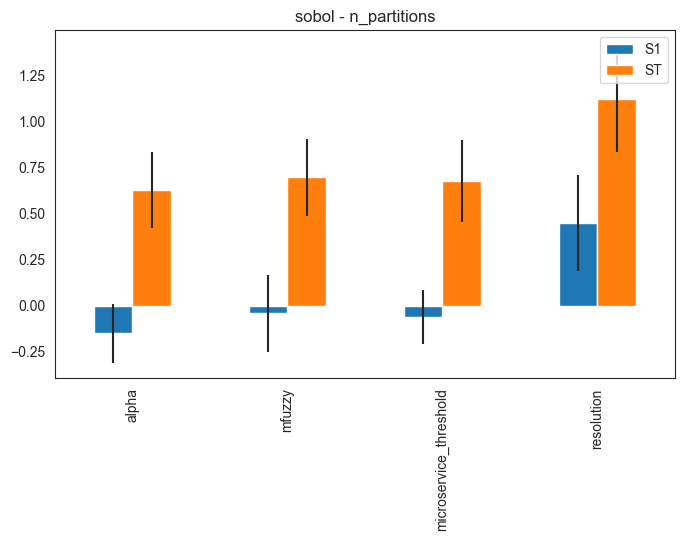

In [172]:
show_sobol(uncertainties_problem, Si_1, title='sobol - n_partitions')
#show_sobol(uncertainties_problem, Si_1, title='sobol - n_partitions (jpetstore)', filename="sobol_n_partitions_jpetstore.png")
#show_sobol(uncertainties_problem, Si_1, title='sobol - n_partitions (cargo)', filename="sobol_n_partitions_cargo.png")

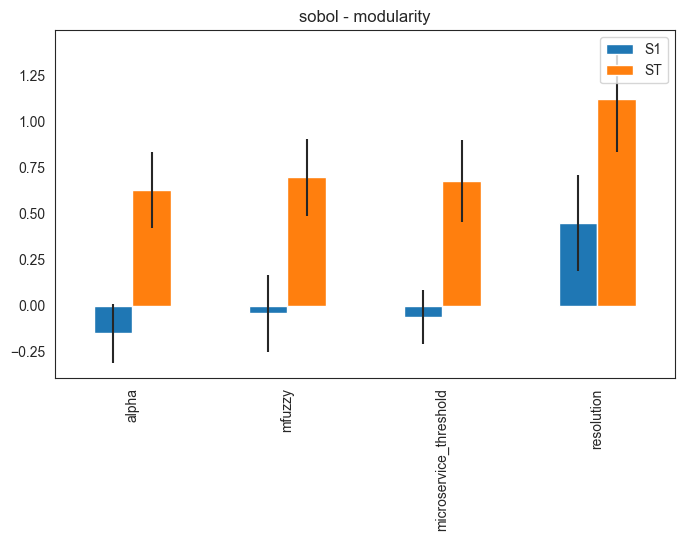

In [173]:
show_sobol(uncertainties_problem, Si_1, title='sobol - modularity')
#show_sobol(uncertainties_problem, Si_1, title='sobol - modularity (jpetstore)', filename="sobol_modularity_jpetstore.png")
#show_sobol(uncertainties_problem, Si_1, title='sobol - modularity (cargo)', filename="sobol_modularity_cargo.png")